In [37]:
import pandas as pd
import elapid as ela
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.inspection import partial_dependence, permutation_importance
import warnings
import joblib
import json

mpl.style.use("ggplot")
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

### Load kikuyugrass observations, background points, and climate data

In [4]:
data = pd.read_csv("./location_climate_data.csv")
data = data.drop(columns=["Unnamed: 0"])

C:\Users\Maggie\AppData\Local\Temp\ipykernel_17476\2945165606.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./location_climate_data.csv")


In [5]:
data.head()

,lat,long,uuid,label,ai,bio10,bio11,bio12,bio13,bio14,...,sfcWind_max,sfcWind_mean,sfcWind_min,sfcWind_range,swb,swe,vpd_max,vpd_mean,vpd_min,vpd_range
0,34.041287,-118.532091,cf6f9a84-0996-4ded-b2e0-a7bd12d67217,kikuyugrass,0.331897,2950,2862,3857,966,6,...,2068,1885,1704,364,-980,65535,11198,8381,6363,4835
1,32.658961,-117.060481,39f544ee-5509-49ea-a296-19c825217ee1,kikuyugrass,0.286715,2938,2869,2806,571,14,...,1141,1067,986,155,-858,65535,9115,7671,6490,2625
2,35.322144,-120.823204,28751c0a-3cd3-4f64-9058-75e564f328f8,kikuyugrass,0.550209,2912,2851,5192,1067,7,...,2345,2029,1746,599,-756,65535,7355,6367,5158,2197
3,32.737291,-117.126908,192ed8dc-5066-42cb-b58f-8cf69f070b2a,kikuyugrass,0.278504,2939,2866,2782,568,11,...,1301,1210,1116,186,-891,65535,8773,7453,6349,2424
4,32.781962,-117.075417,0064ea02-de18-4098-996b-0814a9935c3b,kikuyugrass,0.268646,2943,2865,2932,602,13,...,1199,1112,1028,171,-889,65535,9545,7793,6481,3064


### Filter selected features
https://chelsa-climate.org/wp-admin/download-page/CHELSA_tech_specification_V2.pdf

In [ ]:
# Features
columns_to_drop = [
    "ai",
    "kg0",
    "kg1",
    "kg2",
    "kg3",
    "kg4",
    "kg5",
    "clt_max",
    "clt_mean",
    "clt_min",
    "clt_range",
    "cmi_max",
    "cmi_mean",
    "cmi_min",
    "cmi_range",
    "gdd5",
    "gddlgd5",
    "gdgfgd5",
    "ngd5",
    "sfcWind_max",
    "sfcWind_mean",
    "sfcWind_min",
    "sfcWind_range",
    "swb",
    "swe",
    "vpd_max",
    "vpd_mean",
    "vpd_min",
    "vpd_range",
]
data = data.drop(columns=columns_to_drop)
data.columns

Index(['lat', 'long', 'uuid', 'label', 'bio10', 'bio11', 'bio12', 'bio13',
       'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'bio1', 'bio2',
       'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9', 'fcf', 'fgd',
       'gdd0', 'gdd10', 'gddlgd0', 'gddlgd10', 'gdgfgd0', 'gdgfgd10', 'gsl',
       'gsp', 'gst', 'hurs_max', 'hurs_mean', 'hurs_min', 'hurs_range', 'lgd',
       'ngd0', 'ngd10', 'npp', 'pet_penman_max', 'pet_penman_mean',
       'pet_penman_min', 'pet_penman_range', 'rsds_max', 'rsds_mean',
       'rsds_min', 'rsds_range', 'scd'],
      dtype='object')

### Setup functions

In [7]:
# Plotting functions
def celsius_to_fahrenheit(c):
    return (c * 9 / 5) + 32


def celsius_range_to_fahrenheit(c_range):
    return c_range * (9 / 5)


def mm_to_inches(mm):
    return mm / 25.4


def partial_dependence_scores(estimator, x, percentiles=(0.025, 0.975), n_bins=20):
    """Compute partial dependence scores for each feature"""
    ncols = x.shape[1]
    means = []
    stdvs = []
    bins_list = []

    for idx in range(ncols):
        pd = partial_dependence(
            estimator,
            x,
            [idx],
            percentiles=percentiles,
            grid_resolution=n_bins,
            kind="individual",
        )
        means.append(pd["individual"][0].mean(axis=0))
        stdvs.append(pd["individual"][0].std(axis=0))
        bins_list.append(pd["grid_values"][0])

    return bins_list, means, stdvs


def transform_bioclimatic_variable(var_name, values):
    """
    Transform bioclimatic variables to appropriate units
    """
    if var_name in ["bio1", "bio5", "bio6", "bio8", "bio9", "bio10", "bio11"]:
        return celsius_to_fahrenheit(values * 0.1 - 273.15)
    elif var_name in ["bio2", "bio7"]:
        return celsius_range_to_fahrenheit(values * 0.1)
    elif var_name in ["bio3", "bio15"]:
        return values * 0.1
    elif var_name == "bio4":
        return celsius_range_to_fahrenheit(values / 100 * 0.01)
    elif var_name in ["bio12", "bio13", "bio14", "bio16", "bio17", "bio18", "bio19"]:
        return mm_to_inches(values * 0.1)
    else:
        return values


def partial_dependence_plot(
    estimator, x, percentiles=(0.025, 0.975), n_bins=20, labels=None, **kwargs
):
    """Plot the response of an estimator across the range of feature values"""
    bins_list, means, stdvs = partial_dependence_scores(
        estimator, x, percentiles=percentiles, n_bins=n_bins
    )

    ncols = x.shape[1]
    figx = int(np.ceil(np.sqrt(ncols)))
    figy = int(np.ceil(ncols / figx))
    fig, ax = plt.subplots(figx, figy, sharey=True, **kwargs)
    ax = ax.flatten()

    # transform and plot each feature
    for idx in range(ncols):
        transformed_bins = transform_bioclimatic_variable(labels[idx], bins_list[idx])

        ax[idx].fill_between(
            transformed_bins,
            means[idx] - stdvs[idx],
            means[idx] + stdvs[idx],
            alpha=0.25,
        )
        ax[idx].plot(transformed_bins, means[idx])
        ax[idx].set_title(labels[idx], fontsize=8)

    # turn off empty plots
    for axi in ax[ncols:]:
        axi.set_visible(False)

    fig.tight_layout()
    return fig, ax

### Setup model and train

In [17]:
# Convert presence points to binary classification
data["class"] = data["label"].apply(lambda x: 1 if x == "kikuyugrass" else 0)

# Create geodataframe
geometry = [Point(xy) for xy in zip(data["long"], data["lat"])]
gdf = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

Presence points: 342
Background points: 9884


c:\Users\Maggie\AppData\Local\Programs\Python\Python312\Lib\site-packages\elapid\geo.py:865: UserWarning: Computing distances using geographic coordinates is bad
  warnings.warn("Computing distances using geographic coordinates is bad")
c:\Users\Maggie\AppData\Local\Programs\Python\Python312\Lib\site-packages\elapid\geo.py:865: UserWarning: Computing distances using geographic coordinates is bad
  warnings.warn("Computing distances using geographic coordinates is bad")


<Figure size 1200x800 with 0 Axes>

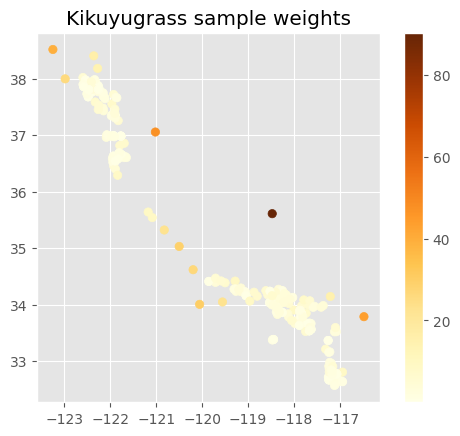

In [26]:
# Split into presence absence and convert distance weights
presence = gdf[gdf["class"] == 1]
background = gdf[gdf["class"] == 0]
print(f"Presence points: {len(presence)}")
print(f"Background points: {len(background)}")

presence["SampleWeight"] = ela.distance_weights(presence, n_neighbors=1)
background["SampleWeight"] = ela.distance_weights(background, n_neighbors=1)

# Plot sample weights
plt.figure(figsize=(12, 8))
presence.plot(column="SampleWeight", legend=True, cmap="YlOrBr")
plt.title(f"Kikuyugrass sample weights")
# plt.savefig(f"./figures/kikuyugrass_sample_weights.png", bbox_inches='tight', dpi=300)
plt.show()

In [29]:
# Prep for modeling
merged = ela.stack_geodataframes(
    presence,
    background,
    add_class_label=True,
)

feature_cols = merged.columns[
    merged.columns.get_loc("bio10") : merged.columns.get_loc("scd") + 1
].tolist()
x = merged[feature_cols].copy()
y = merged["class"]
sample_weight = merged["SampleWeight"]

In [28]:
model = ela.MaxentModel()
model.get_params()

{'beta_categorical': 1.0,
 'beta_hinge': 1.0,
 'beta_lqp': 1.0,
 'beta_multiplier': 1.5,
 'beta_threshold': 1.0,
 'clamp': True,
 'class_weights': 100,
 'convergence_tolerance': 2e-06,
 'feature_types': ['linear', 'hinge', 'product'],
 'n_cpus': 8,
 'n_hinge_features': 10,
 'n_lambdas': 100,
 'n_threshold_features': 10,
 'scorer': 'roc_auc',
 'tau': 0.5,
 'transform': 'cloglog',
 'use_lambdas': 'best',
 'use_sklearn': True}

In [30]:
# Train-test split 70-30
# Validate model performance on held-out test set
x_train, x_test, y_train, y_test, sample_weight_train, sample_weight_test = (
    train_test_split(x, y, sample_weight, test_size=0.3, random_state=42)
)
model.fit(x_train, y_train, sample_weight=sample_weight_train)
y_pred_test = model.predict(x_test)

weighted_auc = metrics.roc_auc_score(
    y_test, y_pred_test, sample_weight=sample_weight_test
)
unweighted_auc = metrics.roc_auc_score(y_test, y_pred_test)
print(f"Train test weighted AUC: {weighted_auc:0.3f}")
print(f"Train test unweighted AUC: {unweighted_auc:0.3f}")

Train test weighted AUC: 0.947
Train test unweighted AUC: 0.960


In [31]:
# Train final model on full dataset, AUC will be optimistic
# Will use this for precition/mapping later
final_model = ela.MaxentModel()
final_model.fit(x, y, sample_weight=sample_weight)
ypred = final_model.predict(x)
full_auc = metrics.roc_auc_score(y, ypred)
print(f"Full model AUC: {full_auc:0.3f}")

Full model AUC: 0.982


In [38]:
# Save
joblib.dump(final_model, "kikuyugrass_maxent_model.joblib")

model_info = {
    "feature_cols": feature_cols,
    "model_params": final_model.get_params(),
    "columns_dropped": columns_to_drop,
}

with open("model_metadata.json", "w") as f:
    json.dump(model_info, f)

### Geographic cross validation

In [33]:
# Geographic cross-validation
test_dfs = []
auc_scores = []
n_splits = 5
gfolds = ela.GeographicKFold(n_splits=n_splits)

print("\nCross-validation results:")

for fold, (train_idx, test_idx) in enumerate(gfolds.split(presence), 1):
    p_train = presence.iloc[train_idx]
    p_test = presence.iloc[test_idx]

    n_bg_train = len(background) // 2
    b_train = background.iloc[:n_bg_train]
    b_test = background.iloc[n_bg_train:]

    train = ela.stack_geodataframes(p_train, b_train)
    test = ela.stack_geodataframes(p_test, b_test)

    xtrain = train[feature_cols]
    ytrain = train["class"]
    sample_weight_train = train["SampleWeight"]
    xtest = test[feature_cols]
    ytest = test["class"]

    model.fit(xtrain, ytrain, sample_weight=sample_weight_train)
    ypred = model.predict(xtest)
    auc = metrics.roc_auc_score(ytest, ypred)
    auc_scores.append(auc)

    print(f"Fold {fold} AUC: {auc:.3f}")

    p_test["fold"] = str(fold)
    test_dfs.append(p_test)

print(f"Mean AUC: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")


Cross-validation results:
Fold 1 AUC: 0.910
Fold 2 AUC: 0.656
Fold 3 AUC: 0.895
Fold 4 AUC: 0.885
Fold 5 AUC: 0.873
Mean AUC: 0.844 ± 0.095


<Figure size 1200x800 with 0 Axes>

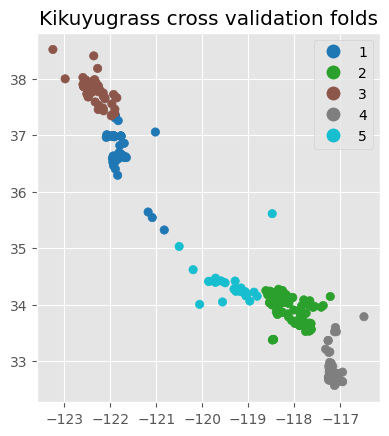

In [23]:
# Plot CV folds
folds = gpd.GeoDataFrame(pd.concat(test_dfs, axis=0, ignore_index=True), crs=test.crs)
plt.figure(figsize=(12, 8))
folds.plot(column="fold", legend=True)
plt.title("Kikuyugrass cross validation folds")
# plt.savefig("./figures/kikuyugrass_cv_folds.png", bbox_inches='tight', dpi=300)
plt.show()

### Figures

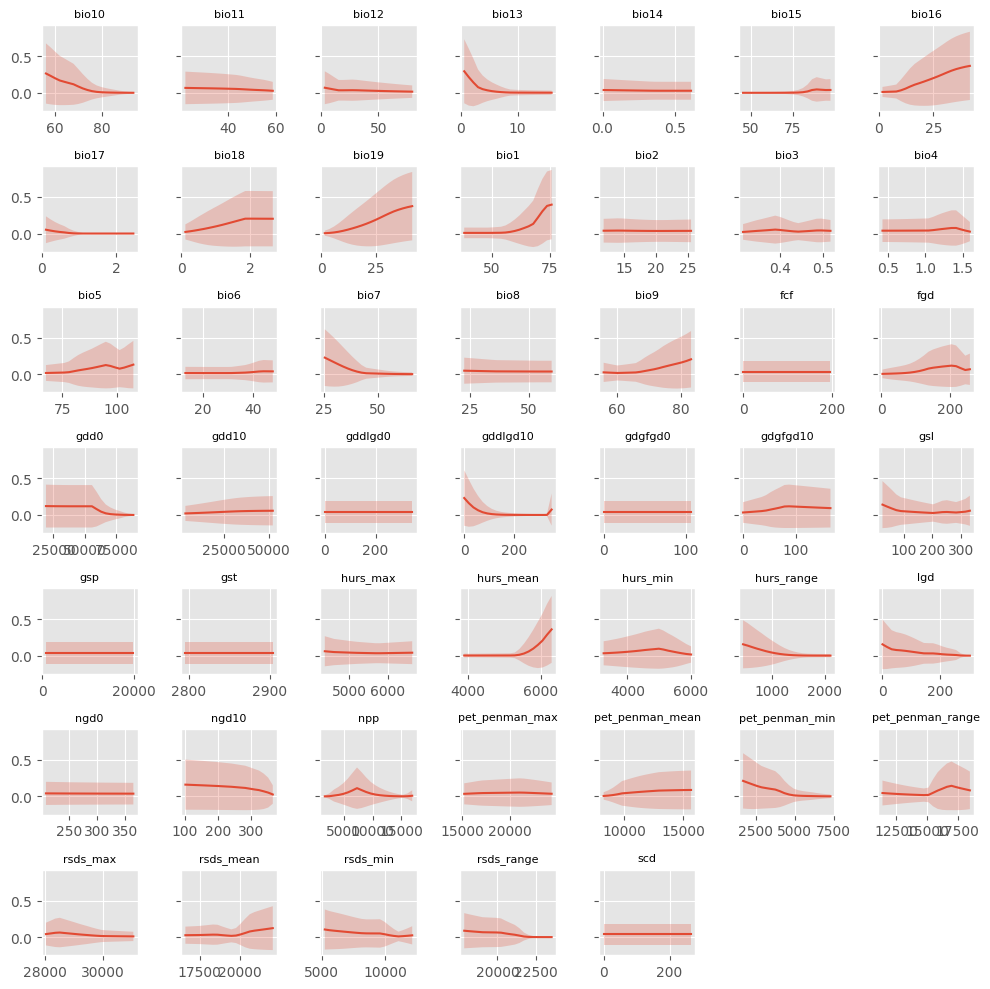

In [34]:
# Partial dependence plots
labels = feature_cols
fig, ax = partial_dependence_plot(
    final_model, x, labels=labels, figsize=(10, 10), dpi=100
)
# plt.savefig("./figures/kikuyugrass_partial_dependence.png", bbox_inches='tight', dpi=300)
plt.show()

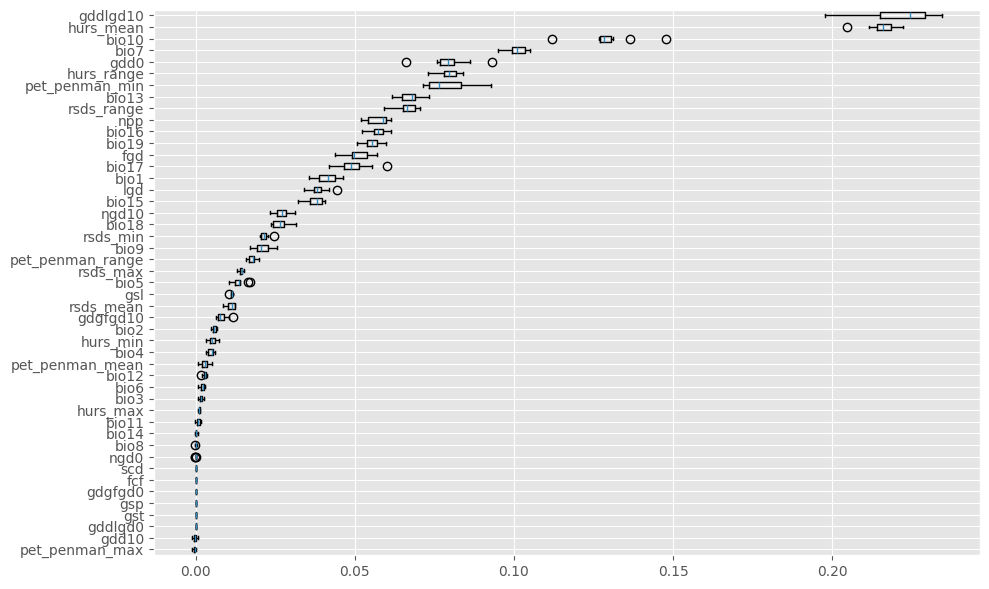

In [35]:
# Permutation importance plot
result = permutation_importance(final_model, x, y, n_repeats=10, random_state=42)

sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(labels)[sorted_idx],
)
fig.tight_layout()
# plt.savefig("./figures/kikuyugrass_permutation_importance.png", bbox_inches='tight', dpi=300)
plt.show()